In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
# X.shape # (70000, 784)
# y.shape #(70000, )


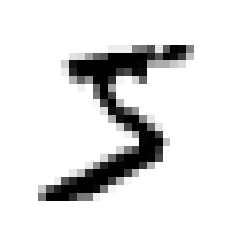

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

y = y.astype(np.uint8)

some_digit = np.array(X.loc[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
X_train, X_test, y_train, y_test = X.loc[:60000], X.loc[60000:], y.loc[:60000], y.loc[60000:]
X_train.loc[0]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier # Stochastic Gradient Deesend classifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train.values, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9304034798260087
0.9536
0.96085


In [7]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy",)

array([0.9580021, 0.9543   , 0.9661   ])

In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91120444, 0.9086    , 0.90915   ])

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [10]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_train_5, y_train_pred)
conf_mat

array([[53901,   679],
       [ 1552,  3869]])

In [11]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions) # what perfect confusion matrix looks like

array([[54580,     0],
       [    0,  5421]])

In [12]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) #TP / (TP + FP) = 0.8143077516390281 , chance of correct guess
recall_score(y_train_5, y_train_pred) # TP / (TP + FN) = 0.779007563180225 , chance of detection

0.7137059583102748

In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred) # 2 * precision * recall / (precision + recall)

0.77620623934196

In [14]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1417.98952709])

In [15]:
threshold = 0 # Changing this decreases recall, misses a 5 
y_some_digit_pred = (y_scores > threshold)

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

54439
-45.098343262201254


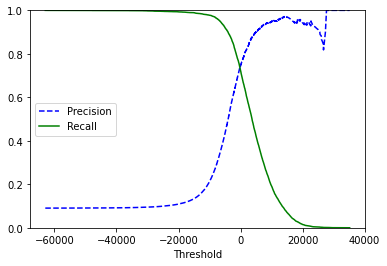

In [16]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
print(np.argmin(abs(recalls - precisions)))
print(thresholds[54557])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [17]:
# threshold = thresholds[np.argmin(abs(recalls - precisions))]
threshold = thresholds[np.where(np.isclose(0.9, precisions))][0]
print(threshold)
y_train_pred_90 = (y_scores > threshold)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)
# can choose any precision but at the cost of recall.

25543.468810612387


0.003135952776240546

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

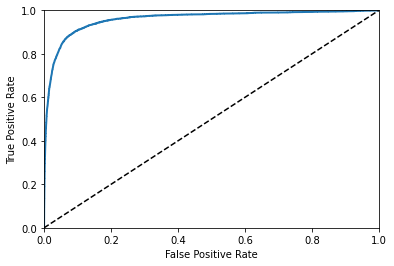

0.9593724958021576

In [19]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()
roc_auc_score(y_train_5, y_scores)

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train RandomForestClassifier to classify 5 or not-5.

forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_train_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

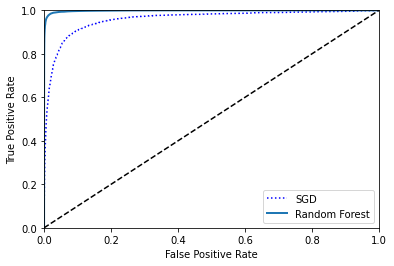

In [21]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()
# roc_auc_score(y_train_5, y_scores_forest) # 0.9982830687278124
# precision_score(y_train_5, y_train_pred) # 0.990069723219945
# recall_score(y_train_5, y_train_pred) # 0.8644161593801881

In [22]:
sgd_clf.fit(X_train.values, y_train) # multiclass classifier, automaticall OvA
sgd_clf.predict([some_digit])
# Ova = array of probabilities, guess : highest probablity
# OVo = binary classifier, 0 vs 1, 0 vs 2, ..., 0 vs 9, 1 vs 2 etc. 45 classifiers

array([5], dtype=uint8)

In [23]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-11309.10111406, -25478.34242516,  -9874.41519753,
         -1413.31383465, -37445.81040301,    903.7453684 ,
        -24582.08371502,  -8898.16760334, -16250.7753621 ,
        -19971.90611968]])

In [32]:
np.argmax(some_digit_scores) # 5
sgd_clf.classes_ # array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [25]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train.values, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [26]:
len(ovo_clf.estimators_)

45

In [27]:
forest_clf.fit(X_train.values, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [28]:
forest_clf.predict_proba([some_digit]) # array of probabilties

array([[0.  , 0.02, 0.03, 0.11, 0.  , 0.8 , 0.  , 0.02, 0.02, 0.  ]])

In [29]:
# Evaluate classifiers
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86810659, 0.88635   , 0.8809    ])

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90120494, 0.8992    , 0.89965   ])

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

/home/philip/.local/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


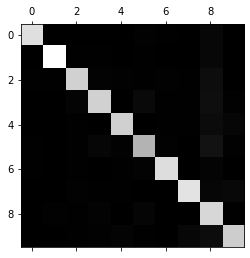

In [33]:
plt.matshow(conf_mx,  cmap=plt.cm.gray)
plt.show()

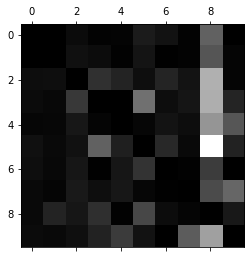

In [36]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [41]:
def plot_digits(image, images_per_row):
    for i in range(int(len(image)/images_per_row - 1)):
        plt.imshow(image[i*images_per_row : (i+1)*images_per_row])


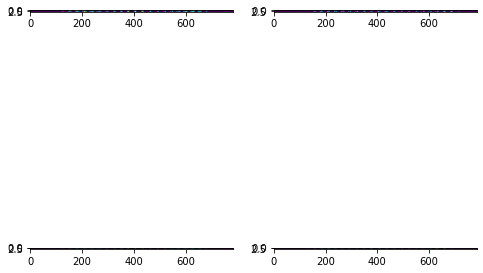

In [45]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [50]:
# Multilabel Classification 
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train.values, y_multilabel)

KNeighborsClassifier()

In [51]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [55]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train.values, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764113687481578

In [73]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


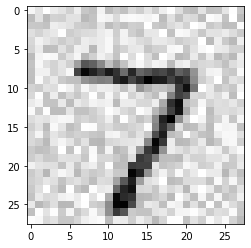

In [74]:
some_noisy_digit = np.array(X_test_mod.loc[60000])
some_noisy_digit_image = some_noisy_digit.reshape(28, 28)

plt.imshow(some_noisy_digit_image, cmap = mpl.cm.binary, interpolation="nearest")

In [78]:
knn_clf.fit(X_train_mod.values, y_train_mod)

KNeighborsClassifier()

In [82]:
clean_digit = knn_clf.predict([some_noisy_digit])

/home/philip/.local/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/philip/.local/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [87]:
clean_digit = clean_digit.reshape(28, 28)

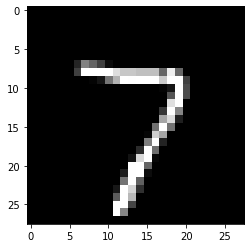

In [89]:
plt.imshow(clean_digit, cmap=plt.cm.gray)